In [1]:
import re
import torch
import spacy
import nltk
import pandas as pd
import numpy as np
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv
from tqdm import tqdm
from collections import Counter
tqdm.pandas()

spacy_en = spacy.load('en_core_web_sm')
stop_words = nltk.corpus.stopwords.words('english')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/thiesen/Documents/Projekt_EDV-TEK/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data

In [2]:
df_cleantech = pd.read_json('/mnt/hdd01/PATSTAT Working Directory/PATSTAT/df_patstat_cleantech_granted_abstract_metadata.json')
df_cleantech['label'] = 1
df_non_cleantech = pd.read_json('/mnt/hdd01/PATSTAT Working Directory/PATSTAT/df_patstat_non_cleantech_granted_abstract_metadata.json')
df_non_cleantech['label'] = 0
df_cleantech = df_cleantech[df_cleantech['appln_abstract'] != '']
df_non_cleantech = df_non_cleantech[df_non_cleantech['appln_abstract'] != '']
df_cleantech.dropna(inplace=True)
df_non_cleantech.dropna(inplace=True)

In [3]:
# df = pd.concat([df_cleantech, df_non_cleantech], ignore_index=True)
df = pd.concat([df_cleantech.sample(10, random_state=42), df_non_cleantech.sample(10, random_state=42)], ignore_index=True)
df = df[['appln_id', 'appln_abstract', 'label']]

## Data Cleaning

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [5]:
df['appln_abstract'] = df['appln_abstract'].astype(str)
df['appln_abstract'] = df['appln_abstract'].progress_apply(preprocess_text)

100%|██████████| 20/20 [00:00<00:00, 3021.83it/s]


## Tokenization

In [6]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
df['appln_abstract_tokens'] = df['appln_abstract'].progress_apply(lambda x: tokenizer(x))

100%|██████████| 20/20 [00:00<00:00, 890.12it/s]


## Build Vocabulary

In [7]:
vocab = build_vocab_from_iterator(df['appln_abstract_tokens'].progress_apply(lambda x: x), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

100%|██████████| 20/20 [00:00<00:00, 54648.91it/s]


In [8]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
tokenized_data = [text_pipeline(text) for text in df['appln_abstract']]

# PyTorch Geomtric Data Preparation

In [16]:
## Helper functions for visualization
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

**Source**
- https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=qoW2Z7P70LNQ
- https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
- https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#data-handling-of-graphs
- For creating larger, custom datasets: https://www.youtube.com/watch?v=QLIkOtKS4os

## Node Features

In [9]:
feature_matrix = torch.zeros(len(tokenized_data), len(vocab), dtype=torch.int64)
for i, doc in enumerate(tokenized_data):
    token_counts = Counter(doc)
    for token, count in token_counts.items():
        feature_matrix[i, token] = count

## Target Vector

In [10]:
target = torch.tensor(df['label'].values, dtype=torch.long)

## Edge Index

In [11]:
df_array = np.array(df)
index = np.array(df['appln_id'])
labels = np.array(df['label'])
indices_label_1 = np.where(labels == 1)[0]
indices_label_0 = np.where(labels == 0)[0]
edges_label_1 = np.array(np.meshgrid(indices_label_1, indices_label_1)).T.reshape(-1, 2)
edges_label_0 = np.array(np.meshgrid(indices_label_0, indices_label_0)).T.reshape(-1, 2)

edges = np.concatenate((edges_label_1, edges_label_0), axis=0)
edges = edges[edges[:, 0] != edges[:, 1]]

bidirectional_edges = np.concatenate((edges, edges[:, [1, 0]]), axis=0)
edge_index = np.unique(bidirectional_edges, axis=0)
edge_index_tensor = torch.from_numpy(edge_index)

In [38]:
num_nodes = len(df)
num_train = int(num_nodes * 0.8)
num_val = int(num_nodes * 0.1)
num_test = num_nodes - num_train - num_val

# Create masks with the correct size
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign True for the indices that belong to each set
train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True

# Create your data object
data = torch_geometric.data.Data(
    x=feature_matrix,
    edge_index=edge_index_tensor.t().contiguous(),
    y=target,
    num_classes=2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

In [40]:
G = to_networkx(data, to_undirected=True)


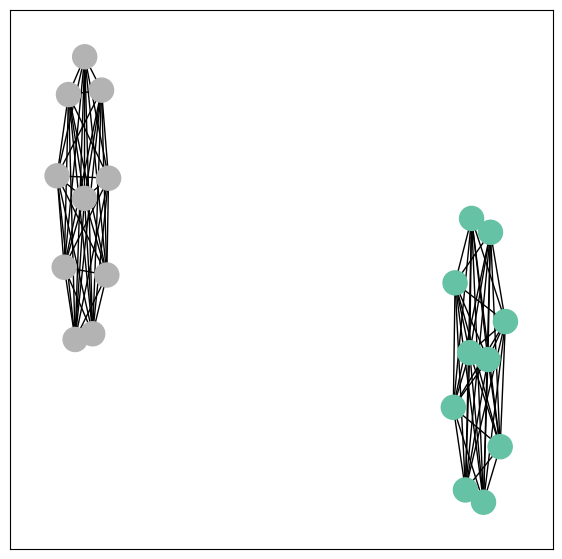

In [41]:
visualize_graph(G, color=data.y)

# Define Model

In [42]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x, edge_index = data.x.float(), data.edge_index.long()
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [43]:
model = GCN(hidden_channels=16)

# Train Model

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.9251
Epoch: 002, Loss: 0.1914
Epoch: 003, Loss: 0.0521
Epoch: 004, Loss: 0.0188
Epoch: 005, Loss: 0.0074
Epoch: 006, Loss: 0.0032
Epoch: 007, Loss: 0.0015
Epoch: 008, Loss: 0.0008
Epoch: 009, Loss: 0.0004
Epoch: 010, Loss: 0.0002
Epoch: 011, Loss: 0.0001
Epoch: 012, Loss: 0.0001
Epoch: 013, Loss: 0.0001
Epoch: 014, Loss: 0.0000
Epoch: 015, Loss: 0.0000
Epoch: 016, Loss: 0.0000
Epoch: 017, Loss: 0.0000
Epoch: 018, Loss: 0.0000
Epoch: 019, Loss: 0.0000
Epoch: 020, Loss: 0.0000
Epoch: 021, Loss: 0.0000
Epoch: 022, Loss: 0.0000
Epoch: 023, Loss: 0.0000
Epoch: 024, Loss: 0.0000
Epoch: 025, Loss: 0.0000
Epoch: 026, Loss: 0.0000
Epoch: 027, Loss: 0.0000
Epoch: 028, Loss: 0.0000
Epoch: 029, Loss: 0.0000
Epoch: 030, Loss: 0.0000
Epoch: 031, Loss: 0.0000
Epoch: 032, Loss: 0.0000
Epoch: 033, Loss: 0.0000
Epoch: 034, Loss: 0.0000
Epoch: 035, Loss: 0.0000
Epoch: 036, Loss: 0.0000
Epoch: 037, Loss: 0.0000
Epoch: 038, Loss: 0.0000
Epoch: 039, Loss: 0.0000
Epoch: 040, Loss: 0.0000
